In [43]:
%matplotlib inline

import obspy
import obspy.signal.trigger as trigger
import matplotlib.pyplot as plt
import numpy as np
from hydrophone_data_processing import load, preprocessing, tempmatch, useful_variables, plotting
from matplotlib.dates import num2date
import event_times as iet
import itertools

hydrophones = {'h1':{'depth':30, 'idx':0}
              ,'h2':{'depth':100, 'idx':1}
              ,'h3':{'depth':170, 'idx':2}
              ,'h4':{'depth':240, 'idx':3}
              ,'h5':{'depth':310, 'idx':4}
              ,'h6':{'depth':380, 'idx':5}}

paths = useful_variables.make_hydrophone_data_paths(borehole='a', year=2019, julian_day=141)
data = load.get_raw_stream(paths=paths)
data.filter(type='highpass', freq=50, corners=1, zerophase=False)

def get_waveforms(starttime):
    """
    Returns a 1 second long trimmed event for the starttime and endtime
    
    Parameters
    -----------------
    starttime : obspy.UTCDatetime
        starttime for the event
        
    Returns
    -----------------
    data : obspy.Stream
        trimmed waveforms for 1 second event window
    """
    starttime = starttime - 0.25
    endtime = starttime + 0.75
    trimmed = data.copy().trim(starttime=starttime, endtime=endtime)
    trimmed.taper(type='hann', max_percentage=0.5)
    return trimmed


def aic_pick(event):
    """
    Uses obspy aic_simple to pick the start time of an event
    
    Parameters
    --------------------
    event : obspy.Stream
        an obspy stream with traces inside. the expected data
        will be only for a single event, not the whole data set
        
    Returns
    --------------------
    aic_t : list
        the times per hydrophone for each aic picked event
    aics : list
        the raw aics calculated for each event
    """
    
    # calculates aic score
    aics = [trigger.aic_simple(tr.data) for tr in event]
    
    # finds minimum and returns index for aic scores
    aic_t_idx = [aic.argmin() for aic in aics]
    
    # uses minimum index to retrieve the timestamp
    aic_t = [event[n].times('matplotlib')[i] for n, i in enumerate(aic_t_idx)]
    
    return aic_t, aics


iet.df.head()

,index,event_times (mpl),event_times (abs),hphone_idx,ones,event_times,p_arrival_hphone_idx
0,0,18037.318174,2019-05-21T07:38:10.208000Z,h3,1,2019-05-21 07:38:10.208000+00:00,2019-05-21 07:38:10.186000+00:00
1,1,18037.318189,2019-05-21T07:38:11.526000Z,h3,1,2019-05-21 07:38:11.526000+00:00,2019-05-21 07:38:11.517000+00:00
2,2,18037.318203,2019-05-21T07:38:12.754000Z,h3,1,2019-05-21 07:38:12.754000+00:00,2019-05-21 07:38:12.723000+00:00
3,3,18037.318219,2019-05-21T07:38:14.141000Z,h3,1,2019-05-21 07:38:14.141000+00:00,2019-05-21 07:38:14.107000+00:00
4,4,18037.318222,2019-05-21T07:38:14.405000Z,h3,1,2019-05-21 07:38:14.405000+00:00,2019-05-21 07:38:14.592000+00:00


In [184]:
class event:

    def __init__(self, id, velocity_model=1600):
        import event_times as iet
        
        self.id = id
        self.velocity_model = velocity_model
        _event = iet.df.iloc[self.id]
        self.starttime = _event['event_times (abs)']
        self.first_hydrophone_id = _event['hphone_idx']
        self.stream = get_waveforms(starttime=self.starttime)
        self.aic_t, self.aics = self.aic_pick()
        
        self._get_second_arrival_hydrophone()
        self.depth = self.get_depth(hA=self.first_hydrophone_id, hB=self.second_hydrophone_id)

    def aic_pick(self):
        """
        Uses obspy aic_simple to pick the start time of an event

        Parameters
        --------------------
        event : obspy.Stream
            an obspy stream with traces inside. the expected data
            will be only for a single event, not the whole data set

        Returns
        --------------------
        aic_t : list
            the times per hydrophone for each aic picked event
        aics : list
            the raw aics calculated for each event
        """

        # calculates aic score
        aics = [trigger.aic_simple(tr.data) for tr in self.stream]

        # finds minimum and returns index for aic scores
        aic_t_idx = [aic.argmin() for aic in aics]

        # uses minimum index to retrieve the timestamp
        aic_t = [self.stream[n].times('matplotlib')[i] for n, i in enumerate(aic_t_idx)]

        return aic_t, aics

    def plot(self, kind):
        if kind == 'waveforms':
            self._plot_waveforms_with_aic()
        if kind == 'event depth':
            self._plot_event_depth()
    
    def _plot_waveforms_with_aic(self):
        fig, axes = plotting.plot_waveforms(self.stream)
        for n, ax in enumerate(axes):
            ax2 = ax.twinx()
            t = self.stream[n].times('matplotlib')
            aic = self.aics[n]
            ax2.plot(t, aic, color='red')
            ax.plot((self.aic_t[n], self.aic_t[n]), (-2000, 2000), color='dodgerblue')
        return fig, axes
    
    def _plot_event_depth(self):
        """
        Plots the depth profile for the event
        """
        x = np.zeros(6)
        h_depths = -1 * np.array([hydrophones[h]['depth'] for h in hydrophones])

        hA_depth = h_depths[hydrophones[self.first_hydrophone_id]['idx']]
        hB_depth = h_depths[hydrophones[self.second_hydrophone_id]['idx']]
        
        fig, ax = plt.subplots(figsize=(5, 15))
        
        # plot hydrophone cable axis
        ax.plot((0, 0), (0, -400), color='black')
        ax.plot(x, h_depths, marker='s', color='black')
        ax.plot((0, 0), (hA_depth, hB_depth), marker='s', color='limegreen')

        ax.set_yticks(h_depths)
        
        # make a label for each hydrophone
        for n, h in enumerate(h_depths):
            ax.text(s='h{n}'.format(n=n+1), x=0.005, y=h)
        
        ax.plot((0,), -self.depth, marker='*', color='red', markersize=15)
    
    def _get_second_arrival_hydrophone(self):
        """
        Uses the time difference between the arrival hydrophone
        and the hydrophone above and below to determine what the 
        next hydrophone arrival time is so it can be used  to 
        estimate the depth.
        
        Parameters
        -----------
        None
        
        Return
        -----------
        None
        """
        # get the arrival hydrophone list index
        first_idx = hydrophones[self.first_hydrophone_id]['idx']
        # get index for hydrophone above arrival hydrophone
        second_idx_above = first_idx - 1

        # get index for hydrophone below arrival hydrophone
        # if the first arrival is on hydrophone 6 there are 
        # no deeper hydrophones so I set it to 0 because this
        # will definitely be far away
        if first_idx >= 5:
            self.second_hydrophone_id = 'h5'
            # end the function here, no need to go on and estimate
            return None
        elif first_idx == 2:
            # hydrophones 1 and 2 are broken
            self.second_hydrophone_id = 'h4'
            return None
        else:
            second_idx_below = first_idx + 1
        
        # take difference in time between hydrophone above and below
        above_tdelta = (num2date(e.aic_t[first_idx]) - num2date(e.aic_t[second_idx_above])).total_seconds()
        below_tdelta = (num2date(e.aic_t[first_idx]) - num2date(e.aic_t[second_idx_below])).total_seconds()
        
        # the minimum time distance is the closer one and therefore the next arrival
        argmin = np.argmin([above_tdelta, below_tdelta])

        if argmin == 0:
            # print(second_idx_above, 'is next')
            self.second_hydrophone_id = 'h'+str(second_idx_above)
        elif argmin == 1:
            # print(second_idx_below, 'is next')
            self.second_hydrophone_id = 'h'+str(second_idx_below)
        else:
            raise ValueError(argmin, 'should be 0 or 1')
            
    def get_depth(self, hA, hB):
        A_idx = hydrophones[hA]['idx']
        B_idx = hydrophones[hB]['idx']
        print(hA, hydrophones[hA])
        print(hB, hydrophones[hB])
        
        t_A = num2date(self.aic_t[A_idx])
        t_B = num2date(self.aic_t[B_idx])
        
        print('t_A', t_A)
        print('t_B', t_B)
        
        dt = (t_A - t_B).total_seconds()
        print('dt:',dt)
        
        dz_A = 35 + 0.5 * self.velocity_model * dt
        print('dz_A:', dz_A)
        print(h_id, hydrophones[hA]['depth'])
        
        return hydrophones[hA]['depth'] + dz_A

In [185]:
[h for h in hydrophones]

['h1', 'h2', 'h3', 'h4', 'h5', 'h6']

In [ ]:
e = event(id=181)
# print('arrival depth A:', dz_A)
# print('estimated depth (meters):', 170 + dz_A)
# print('{ha}, {hb} estimated depth (meters):'.format(ha=e.first_hydrophone_id, hb=e.second_hydrophone_id), e.depth)
e.plot('event depth')
e.plot('waveforms')

In [172]:
iet.df.shape

(1975, 7)

In [97]:
# e = event(id=1974)
# # e._get_second_arrival_hydrophone()
# print('first:', e.first_hydrophone_id)
# print('second:', e.second_hydrophone_id)
# e.plot()

In [41]:
hydrophones[e.first_hydrophone_id]

{'depth': 240, 'idx': 3}

In [68]:
# get the arrival hydrophone list index
first_idx = hydrophones[e.first_hydrophone_id]['idx']

# get index for hydrophone above arrival hydrophone
second_idx_above = first_idx - 1

# get index for hydrophone below arrival hydrophone
second_idx_below = first_idx + 1

# take difference in time between hydrophone above and below
above_tdelta = (num2date(e.aic_t[first_idx]) - num2date(e.aic_t[second_idx_above])).total_seconds()
below_tdelta = (num2date(e.aic_t[first_idx]) - num2date(e.aic_t[second_idx_below])).total_seconds()

# the minimum time distance is the closer one and therefore the next arrival
argmin = np.argmin([above_tdelta, below_tdelta])

if argmin == 0:
    print(second_idx_above, 'is next')
elif argmin == 1:
    print(second_idx_below, 'is next')
else:
    raise ValueError(argmin, 'should be 0 or 1')

4 is next


In [46]:
e.aic_t

[18037.337163391207,
 18037.337163506945,
 18037.337163981483,
 18037.3371653125,
 18037.337165520836,
 18037.337166064815]

In [121]:
e = event(id=750)
t_A = num2date(e.aic_t[3])
t_B = num2date(e.aic_t[4])
dt = (t_A - t_B).total_seconds()
v_TAB = 1600
dz_A = 35 + (1/2) * v_TAB * dt
dz_B = 70 - dz_A
print('arrival depth A:', dz_A)
# print('estimated depth (meters):', 170 + dz_A)
print('estimated depth (meters):', hydrophones[h_id]['depth'] + dz_A) 

arrival depth A: 59.8
estimated depth (meters): 299.8


arrival depth A: 20.6
estimated depth (meters): 260.6


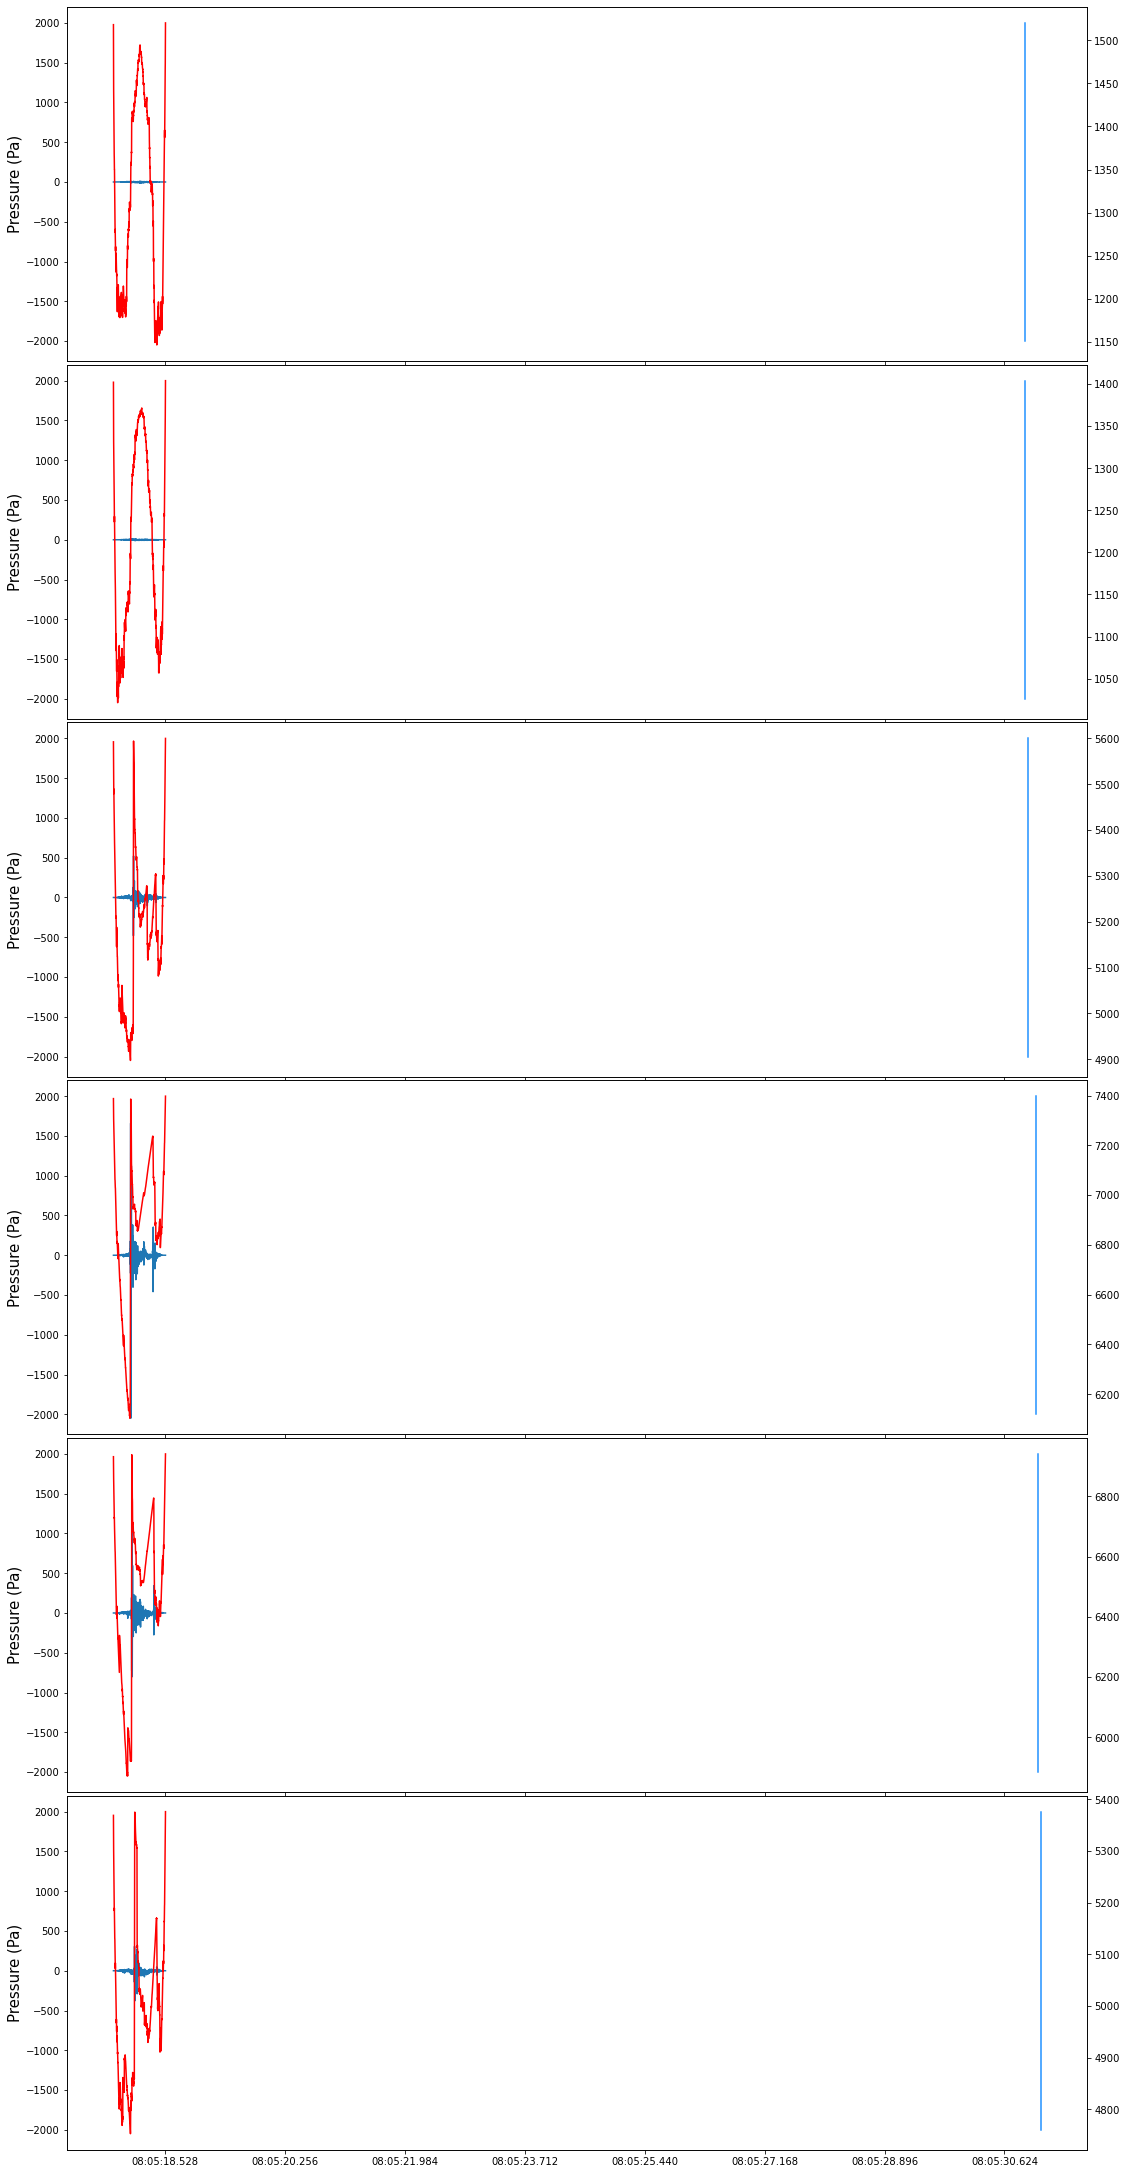

In [122]:
fig, axes = plotting.plot_waveforms(e.stream)
for n, ax in enumerate(axes):
    ax2 = ax.twinx()
    t = e.stream[n].times('matplotlib')
    aic = e.aics[n]
    ax2.plot(t, aic, color='red')
    ax.plot((aic_t[n], aic_t[n]), (-2000, 2000), color='dodgerblue')
    
t_A = num2date(aic_t[3])
t_B = num2date(aic_t[4])
dt = (t_A - t_B).total_seconds()
v_TAB = 1600
dz_A = 35 + (1/2) * v_TAB * dt
dz_B = 70 - dz_A
print('arrival depth A:', dz_A)
# print('estimated depth (meters):', 170 + dz_A)
print('estimated depth (meters):', hydrophones[h_id]['depth'] + dz_A)    

arrival depth A: 20.6
estimated depth (meters): 260.6
index                                                462
event_times (mpl)                           18037.337165
event_times (abs)            2019-05-21T08:05:31.098000Z
hphone_idx                                            h4
ones                                                   1
event_times             2019-05-21 08:05:31.098000+00:00
p_arrival_hphone_idx    2019-05-21 08:05:31.083000+00:00
Name: 760, dtype: object


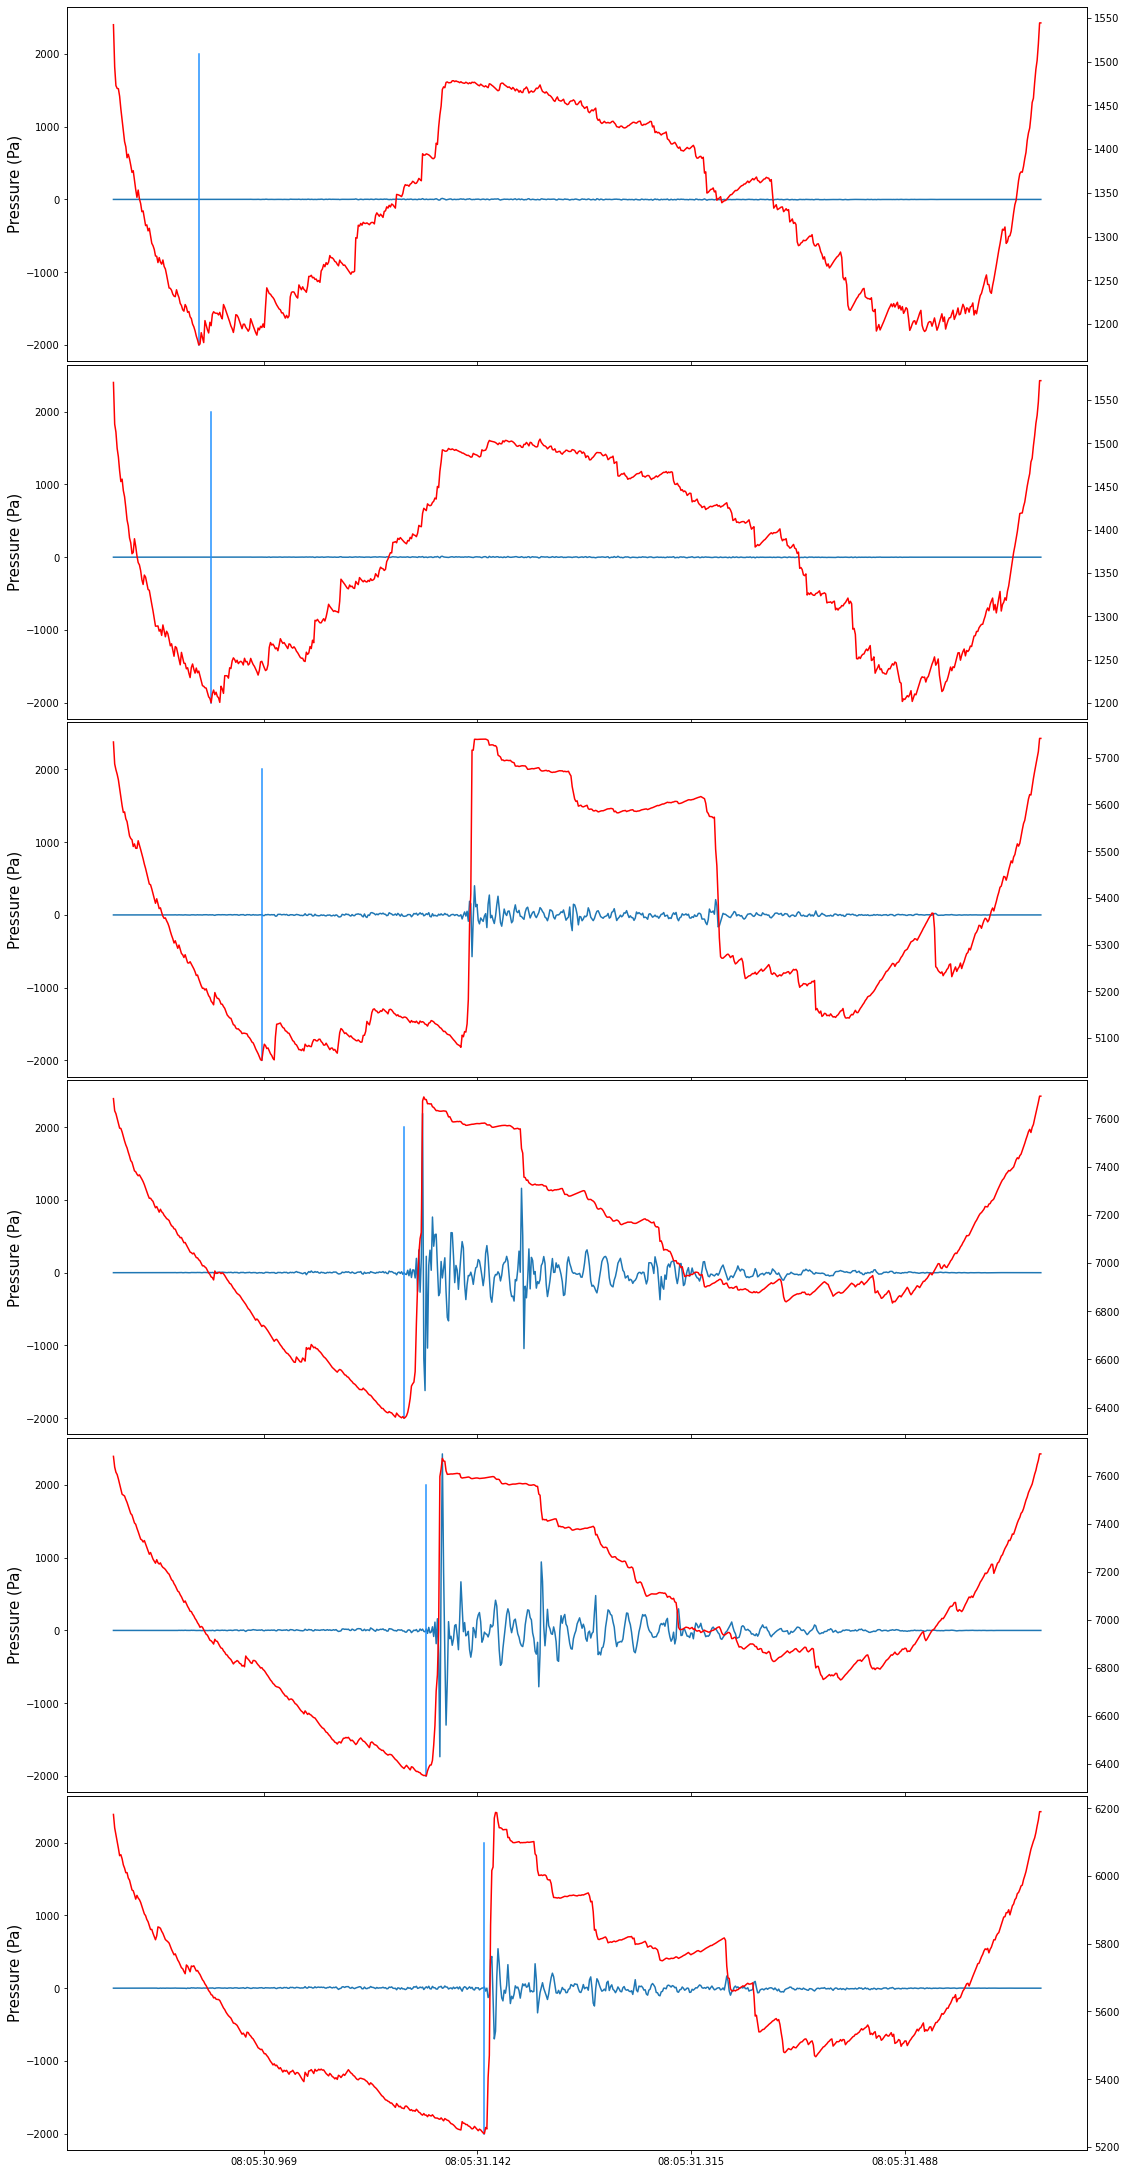

In [2]:
iet_e = iet.df.iloc[760]
starttime = iet_e['event_times (abs)']
h_id = iet_e['hphone_idx']
e = get_waveforms(starttime=starttime)
aic_t, aics = aic_pick(e)

fig, axes = plotting.plot_waveforms(e)
for n, ax in enumerate(axes):
    ax2 = ax.twinx()
    t = e[n].times('matplotlib')
    aic = aics[n]
    ax2.plot(t, aic, color='red')
    ax.plot((aic_t[n], aic_t[n]), (-2000, 2000), color='dodgerblue')

t_A = num2date(aic_t[3])
t_B = num2date(aic_t[4])
dt = (t_A - t_B).total_seconds()
v_TAB = 1600
dz_A = 35 + (1/2) * v_TAB * dt
dz_B = 70 - dz_A
print('arrival depth A:', dz_A)
# print('estimated depth (meters):', 170 + dz_A)
print('estimated depth (meters):', hydrophones[h_id]['depth'] + dz_A)
print(iet.df.iloc[760])

In [3]:
[num2date(a) for a in aic_t]

[datetime.datetime(2019, 5, 21, 8, 5, 30, 917000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 30, 927000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 30, 968000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 31, 83000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 31, 101000, tzinfo=datetime.timezone.utc),
 datetime.datetime(2019, 5, 21, 8, 5, 31, 148000, tzinfo=datetime.timezone.utc)]